In [1]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
#!pip install --upgrade oracledb
#!pip install --upgrade folium

In [2]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
import folium
import requests
from bs4 import BeautifulSoup
import re

# Présentation générale de l'édition des JO qui vous a été assignée

### Récupérer les coordonnées des lieux et les mettres sur une carte

In [3]:
sydney_coords = [-33.8688, 151.2093]
# Créer une carte centrée sur l'australie 
australia_map = folium.Map(location=sydney_coords, zoom_start=5, width=1200, height=250)

# Ajouter un marqueur pour Sydney
folium.Marker(location=sydney_coords, popup='Sydney').add_to(australia_map)
# Définir l'URL pour les épreuves olympiques
url = 'https://www.olympedia.org/venues/editions/25'

# Récupérer le contenu de la page
request = requests.get(url)    
# récupérer le code HTML de la page
codeHTML = BeautifulSoup(request.text, 'html')  
# rechercher la table contenant les épreuve
codeHTML = codeHTML.find('table', class_='table table-striped')   
# ne garder que les lignes contenant un lien vers un lieu
table = codeHTML.find_all('a', href=lambda href: href and '/venues/7' in href)    
# Extraire le href et le nom du lieu
table = [{'href': lien['href'], 'nom': lien.text} for lien in table]

url_lieu = "https://www.olympedia.org"
marker_table = []
for lien in table :
    url_lieu_modif = url_lieu + lien['href']
    request = requests.get(url_lieu_modif)    
    codeHTML = BeautifulSoup(request.text, 'html')  # récupérer le code HTML de la page
    coordonnee = codeHTML.find(string=re.compile("(Definitely here)"))
    pattern = r'(-?\d+\.\d+),\s*(-?\d+\.\d+)'
    matches = re.search(pattern, coordonnee)
    latitude = matches.group(1)
    longitude = matches.group(2)
    coords = [latitude, longitude]
    folium.Marker(location=coords).add_to(australia_map)
# afficher la carte des épreuves 
australia_map

### Importation de la base de donnnées

In [4]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion, requete, valeurs = None):
    warnings.simplefilter(action='ignore', category=UserWarning)
    if valeurs is not None:
        df = pd.read_sql(requete, connexion, params=valeurs)
    else:
        df = pd.read_sql(requete, connexion)
    warnings.simplefilter("always") 
    return df

In [5]:
# Saisir ci-dessous l'édition des JO qui vous a été attribuée. Cela correspond au LibelleHote dans la table HOTE de la base de données
# Par exemple EDITION_JO = "2020 Summer Olympics"
EDITION_JO = "2000 Summer Olympics"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = "KLENTZ"

In [6]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS_PASS")
conn = oracledb.connect(user=login, password=password, host="oracle.iut-orsay.fr", port=1521, sid="etudom")
conn.autocommit = False

Login :  KLENTZ
Mot de passe :  ········


In [7]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.HOTE WHERE LibelleHote LIKE (:libelle)",{"libelle":EDITION_JO})
id_hote = int(data.IDHOTE.iloc[0])
print(f"Identifiant de l’hôte : {id_hote}")

Identifiant de l’hôte : 25


In [8]:
# Calculer avec une requête et afficher les épreuves nouvellement ajoutée à cette édition
nvlleEpreuve  = requete_vers_dataframe(conn, f"""SELECT DISTINCT nomDiscipline FROM {SCHEMA}.DISCIPLINE
NATURAL JOIN {SCHEMA}.EVENEMENT
WHERE idHote = {id_hote} AND nomDiscipline NOT IN (SELECT nomDiscipline FROM {SCHEMA}.DISCIPLINE
                                            NATURAL JOIN {SCHEMA}.EVENEMENT
                                            WHERE idHote = {id_hote}-1)""")

nvlleEpreuve

,NOMDISCIPLINE
0,Triathlon
1,Trampolining
2,Taekwondo


In [23]:
# Calculer avec une requête et afficher le nombre d'épreuve de chaque genre
hoteSummer  = requete_vers_dataframe(conn, f"""SELECT idHote, anneeHote FROM {SCHEMA}.HOTE
WHERE Saison ='Summer'""")
resultats = []

for i in range (len(hoteSummer)) :
    idHoteSummer = hoteSummer.loc[i, 'IDHOTE']
    anneeHoteSummer = hoteSummer.loc[i, 'ANNEEHOTE']
    genreEpreuveWomen  = requete_vers_dataframe(conn, f"""SELECT DISTINCT NomDiscipline, nomEvenement FROM {SCHEMA}.EVENEMENT E
    NATURAL JOIN {SCHEMA}.DISCIPLINE
    INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
    NATURAL JOIN {SCHEMA}.ATHLETE
    WHERE idHote = {idHoteSummer} AND nomEvenement LIKE '%Women%'""")

    genreEpreuveMen  = requete_vers_dataframe(conn, f"""SELECT DISTINCT NomDiscipline, nomEvenement FROM {SCHEMA}.EVENEMENT E
    NATURAL JOIN {SCHEMA}.DISCIPLINE
    INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
    NATURAL JOIN {SCHEMA}.ATHLETE
    WHERE idHote = {idHoteSummer} AND nomEvenement LIKE '%Men%'""")

    nbWomen = genreEpreuveWomen['NOMDISCIPLINE'].count()
    nbMen = genreEpreuveMen['NOMDISCIPLINE'].count()
     # Ajouter les résultats à la liste
    resultats.append({'anneeHoteSummer': anneeHoteSummer, 'nbMen': nbMen, 'nbWomen': nbWomen})

# Créer un DataFrame à partir des résultats
df_resultats = pd.DataFrame(resultats)
    

In [28]:
df_resultats = df_resultats.loc[(df_resultats['nbMen'] != 0) | (df_resultats['nbWomen'] != 0)]

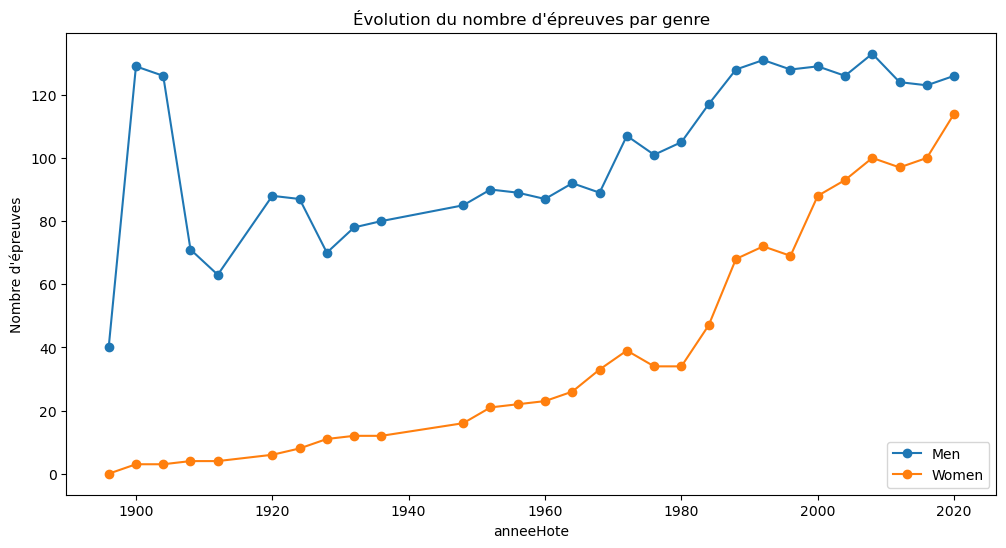

In [29]:
# Tracer les données avec matplotlib
plt.figure(figsize=(12, 6))  # Définir la taille de la figure

# Tracer nbMen
plt.plot(df_resultats.anneeHoteSummer, df_resultats['nbMen'], marker='o', linestyle='-', label='Men')

# Tracer nbWomen
plt.plot(df_resultats.anneeHoteSummer, df_resultats['nbWomen'], marker='o', linestyle='-', label='Women')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('anneeHote')
plt.ylabel('Nombre d\'épreuves')
plt.title('Évolution du nombre d\'épreuves par genre')
plt.legend()

# Comparaison de cette édition avec les éditions qui l'ont précédée

### classement des nations (tableau de classement pour les trois couleurs de médailles et pour le total) + répartition des médailles par couleur et par pays.

### répartition des médailles par genre et par pays, comparaison à l'aide de la moyenne/écart-type et min/max/quartiles/médiane.

### répartition des médailles par continent (Amérique, Europe, Asie, Afrique, Océanie), comparaison là aussi avec les outils vus en statistiques. [Bonus]

### autres idées de répartitions pertinentes [Bonus]

### évolution de ces classements par rapport à l'édition précédente [Bonus]

### évolution à long terme pour le top 3 de cette édition (c'est-à-dire que pour les trois meilleurs pays de cette édition, on veut savoir quelle était leur performance sur les jeux de même type (jeux d'été ou jeux d'hiver) lors des éditions qui ont précédé).

### tailles des délégations (et tendances à long terme). [Bonus]

### moyennes d'âge des athlètes (et tendances à long terme).

### tailles des athlètes (et tendances à long terme). [Bonus]

### féminisation : nombre d'événements féminins, nombre d'athlètes femme (et tendance à long terme).

# Performance de l'équipe de votre choix